# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [1]:
# sudo modprobe nvidia_uvm
import torch
torch.cuda.is_available()

True

In [4]:
import json

In [5]:
dataset_name = "DATASET"
dataset_path = f'../segments/{dataset_name}'

In [6]:
# 48 kHz sampling rate (from BirdNET docs)
# we compute 2 mel spectrograms as input for the convolutional neural network:
# first one has fmin = 0 Hz and fmax = 3000; nfft = 2048; hop size = 278; 96 mel bins
# second one has fmin = 500 Hz and fmax = 15 kHz; nfft = 1024; hop size = 280; 96 mel bins
# both spectrograms have a final resolution of 96x511 pixels
# raw audio will be normalized between -1 and 1 before spectrogram conversion
# we use non-linear magnitude scaling as mentioned in Schlüter 2018

config = {
    "fixed_duration": 3.0,
    "sample_rate": 48000,
    "mel_params": {
      "n_mels": 96,
      "hop_length": 280,
      "f_min": 500,
      "f_max": 15000,
      "n_fft": 1024,
    }
}

In [7]:
with open("utils/category_info.json") as f:
    category_info = json.load(f)

mappings = {species: i for i, species in enumerate(category_info.keys())}
mappings["Wind_"]

0

In [8]:
import os
samples_train = {}
train_folder = f"{dataset_path}/train"
test_folder = f"{dataset_path}/test"
for species in os.listdir(train_folder):
    for audio in os.listdir(os.path.join(train_folder, species)):
        if audio in samples_train:      # same audio in different folders, save the other species
            samples_train[audio]["labels"].append(mappings[species])
            continue
        samples_train[audio] = {
            "file_path": os.path.join(train_folder, species, audio),
            "split": "train",
            "labels": [mappings[species]]
        }


In [9]:
samples_test = {}
for species in os.listdir(test_folder):
    for audio in os.listdir(os.path.join(test_folder, species)):
        labels = [mappings[species]]
        updated = False
        if audio in samples_test:       # adds label
            samples_test[audio]["labels"].extend(labels)
            updated = True
        if audio in samples_train:      # considers training labels
            samples_train[audio]["labels"].extend(labels)       # add test label
            labels = samples_train[audio]["labels"]             # save new labels
        if updated:
            continue
        samples_test[audio] = {
            "file_path": os.path.join(test_folder, species, audio),
            "split": "test",
            "labels": labels
        }

In [10]:
samples = []
for audio_name, props in samples_train.items():
    samples.append(props)
for audio_name, props in samples_test.items():
    samples.append(props)
samples[:2]

[{'file_path': '../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_162.wav',
  'split': 'train',
  'labels': [5]},
 {'file_path': '../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_131.wav',
  'split': 'train',
  'labels': [5, 2]}]

In [11]:
info_json = {
    "config": config,
    "mappings": mappings,
    "samples": samples
}

In [12]:
with open(f"utils/{dataset_name}/dataset_config.json", "w") as f:
    json.dump(info_json, f)

# Dataset and Data Loader
Use the dataset information to create a data loader for the model

In [13]:
import json
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
class AudioDataset(Dataset):

    def __init__(self, json_path, split="train"):
        with open(json_path, "r") as f:
            data = json.load(f)

        self.config = data["config"]
        self.sample_rate = self.config["sample_rate"]
        self.n_mels = self.config["mel_params"]["n_mels"]
        self.hop_length = self.config["mel_params"]["hop_length"]
        self.f_min = self.config["mel_params"]["f_min"]
        self.f_max = self.config["mel_params"]["f_max"]
        self.n_fft = self.config["mel_params"]["n_fft"]

        self.label_map = data["mappings"]
        self.num_classes = len(self.label_map)

        self.samples = [sample for sample in data["samples"] if sample["split"] == split]
        self.target_samples = self.sample_rate * 3

        self.mel_transform = T.MelSpectrogram(
            f_min=self.f_min,
            f_max=self.f_max,
            n_fft=self.n_fft,
            sample_rate=self.sample_rate,
            n_mels=self.n_mels,
            hop_length=self.hop_length,
        )

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        try:
            waveform, sr = torchaudio.load(sample["file_path"])
            print(f"Loaded audio with shape: {waveform.shape}, sample rate: {sr}")
        except RuntimeError as e:
            print(f"Error loading audio: {e}")

        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)

        num_samples = waveform.shape[1]
        if num_samples < self.target_samples:
            pad = self.target_samples - num_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad))
        
        mel_spec = self.mel_transform(waveform).squeeze(0)  # (n_mels, time)

        # label one-hot
        label_tensor = torch.zeros(self.num_classes)
        for label in sample["labels"]:
            label_tensor[label] = 1.0

        return mel_spec, label_tensor, sample["file_path"]


In [24]:
json_path = "utils/dataset_config.json"
def get_dataloader(json_path, split='train', batch_size=32, shuffle=True):
    dataset = AudioDataset(json_path, split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
get_dataloader(json_path)

torch.Size([96, 515]) torch.Size([31])
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_131.wav


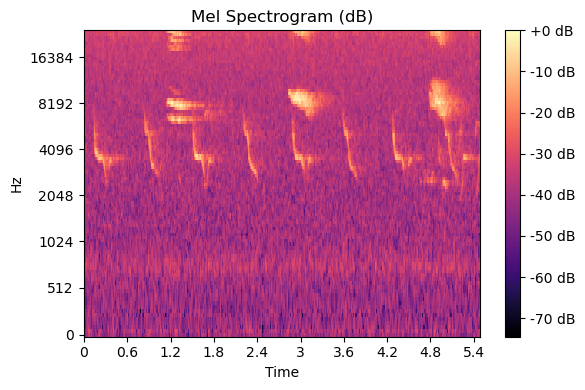

In [25]:
import matplotlib.pyplot as plt
import librosa

dataset = AudioDataset(json_path, split="train")
mel_spec, label, path = dataset[1] 
print(mel_spec.shape, label.shape)
print(path)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(6, 4))
librosa.display.specshow(mel_spec, sr=dataset.sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')
plt.tight_layout()
plt.show()


In [26]:
for mel_spec, label, name in dataset:
    print(name)
    if mel_spec.shape[0] != 96 or mel_spec.shape[1] != 515:
        print(mel_spec.shape, name)

../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_162.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_131.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_137.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_123.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_12.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_169.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_183.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_8.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_126.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_144.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_150.wav
../segments/DATASET/train/Muscicapa striata_Sp

../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_118.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_136.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_110000_46.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_196.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_188.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_130.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_190.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_122.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_152.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_165.wav
../segments/DATASET/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_20.wav
../segments/DATASET/train/Muscicapa striata_S

RuntimeError: Failed to decode audio.

# Model

In [ ]:
import torch.nn as nn
import torch.optim as optim

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Aggiunge canale per convoluzioni
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))  # Multi-label classification
        return x

In [30]:
def train_model(json_path, epochs=10, batch_size=10, lr=0.001):
    train_loader = get_dataloader(json_path, split="train", batch_size=batch_size)
    # test_loader = get_dataloader(json_path, split="test", batch_size=batch_size, shuffle=False)

    num_classes = len(json.load(open(json_path))['mappings'])
    model = AudioCNN(num_classes=num_classes)
    model = AudioCNN(num_classes).cuda()

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"Starting epoch: {epoch}")
        for mel_spec, labels, _ in train_loader:
            mel_spec, labels = mel_spec.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    return model


In [31]:
train_model(json_path)

Starting epoch: 0


RuntimeError: Caught RuntimeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 271, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable
